### Load mat data

In [1]:
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from __future__ import division

In [2]:
mat_contents = sio.loadmat('/Users/dalin/Documents/My_Research/Dataset/ALM_Svoboda_Lab_Data/Code/TLDS/TempDat/Simultaneous_Spikes.mat')

In [3]:
nDataSet = mat_contents['nDataSet']
params = mat_contents['params']

In [4]:
# nDataSet[0, 0][0].flatten()[0] # sessionIndex
# nDataSet[0, 0][1].flatten() # nUnit
# nDataSet[0, 0][2] # unitROCIndex
# nDataSet[0, 0][3].flatten() # unit_yes_trial_index
# nDataSet[0, 0][4].flatten() # unit_no_trial_index
# nDataSet[0, 0][5] # unit_yes_trial, trial x unit x Time
# nDataSet[0, 0][6] # unit_no_trial, trial x unit x Time
# nDataSet[0, 0][7].flatten() # totTargets
# nDataSet[0, 0][8].flatten() # firstLickTime

In [5]:
nSession = 17 # matlab index
nSession = nSession - 1
totTargets = nDataSet[0, nSession][7].flatten()
unit_yes_trial = nDataSet[0, nSession][5]
unit_no_trial = nDataSet[0, nSession][6]

In [6]:
from pybasicbayes.util.text import progprint_xrange
from pylds.util import random_rotation
from pyslds.models import DefaultSLDS
import numpy.random as npr

In [7]:
unit_trial = np.concatenate((unit_yes_trial, unit_no_trial))
numTrial, numUnit, numTime = unit_trial.shape
unit_trial = unit_trial.transpose([0, 2, 1])
unit_trial = unit_trial.reshape([-1, unit_trial.shape[2]])

In [8]:
# plt.plot(unit_trial[:, 8].reshape(numTrial, numTime)[40,:])

In [9]:
np.random.seed(10)
# transition
K = 8
yDim = numUnit
xDim = 5
inputDim = 1 # some constants
inputs = np.ones((numTrial * numTime, inputDim))

In [10]:
test_model = DefaultSLDS(K, yDim, xDim, inputDim,
                         Cs=npr.randn(yDim, xDim),
                         Ds=npr.randn(yDim, inputDim))
test_model.add_data(unit_trial, inputs=inputs)

In [11]:
print("Initializing with Gibbs")
N_gibbs_samples = 1000
def initialize(model):
    model.resample_model()
    return model.log_likelihood()

gibbs_lls = [initialize(test_model) for _ in progprint_xrange(N_gibbs_samples)]

Initializing with Gibbs
.........................  [   25/1000,    0.12sec avg, ETA 01:52 ]
.........................  [   50/1000,    0.11sec avg, ETA 01:49 ]
.........................  [   75/1000,    0.11sec avg, ETA 01:46 ]
.........................  [  100/1000,    0.11sec avg, ETA 01:42 ]
.........................  [  125/1000,    0.11sec avg, ETA 01:39 ]
.........................  [  150/1000,    0.11sec avg, ETA 01:37 ]
.........................  [  175/1000,    0.12sec avg, ETA 01:35 ]
.........................  [  200/1000,    0.11sec avg, ETA 01:32 ]
.........................  [  225/1000,    0.11sec avg, ETA 01:28 ]
.........................  [  250/1000,    0.11sec avg, ETA 01:25 ]
.........................  [  275/1000,    0.11sec avg, ETA 01:22 ]
.........................  [  300/1000,    0.11sec avg, ETA 01:18 ]
.........................  [  325/1000,    0.11sec avg, ETA 01:15 ]
.........................  [  350/1000,    0.11sec avg, ETA 01:12 ]
........................

In [12]:
# Fit with VBEM
print("Fitting with VBEM")
N_vbem_iters = 1000
def update(model):
    model.VBEM_step()
    return model.log_likelihood()

test_model.states_list[0]._init_mf_from_gibbs()
vbem_lls = [update(test_model) for _ in progprint_xrange(N_vbem_iters)]

Fitting with VBEM
..

/Users/dalin/anaconda/envs/py2/lib/python2.7/site-packages/pyhsmm/internals/hmm_states.py:675: RuntimeWarning: divide by zero encountered in log
  np.log(trans_potential),likelihood_log_potential,alphal,betal,


.......................  [   25/1000,    0.21sec avg, ETA 03:29 ]
.........................  [   50/1000,    0.21sec avg, ETA 03:22 ]
.........................  [   75/1000,    0.21sec avg, ETA 03:12 ]
.........................  [  100/1000,    0.21sec avg, ETA 03:06 ]
.........................  [  125/1000,    0.21sec avg, ETA 02:60 ]
.........................  [  150/1000,    0.21sec avg, ETA 02:55 ]
.........................  [  175/1000,    0.21sec avg, ETA 02:51 ]
.........................  [  200/1000,    0.21sec avg, ETA 02:46 ]
.........................  [  225/1000,    0.21sec avg, ETA 02:42 ]
.........................  [  250/1000,    0.21sec avg, ETA 02:38 ]
.........................  [  275/1000,    0.21sec avg, ETA 02:33 ]
.........................  [  300/1000,    0.21sec avg, ETA 02:28 ]
.........................  [  325/1000,    0.21sec avg, ETA 02:23 ]
.........................  [  350/1000,    0.21sec avg, ETA 02:17 ]
.........................  [  375/1000,    0.21sec

In [13]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

# Fancy plotting
try:
    import seaborn as sns
    from hips.plotting.colormaps import gradient_cmap
    sns.set_style("white")
    sns.set_context("paper")

    color_names = ["red",
                   "windows blue",
                   "medium green",
                   "dusty purple",
                   "orange",
                   "amber",
                   "clay",
                   "pink",
                   "greyish",
                   "light cyan",
                   "steel blue",
                   "forest green",
                   "pastel purple",
                   "mint",
                   "salmon",
                   "dark brown"]
    colors = sns.xkcd_palette(color_names)
    cmap = gradient_cmap(colors)
except:
    from matplotlib.cm import get_cmap
    colors = ['b', 'r', 'y', 'g', 'purple']
    cmap = get_cmap("jet")

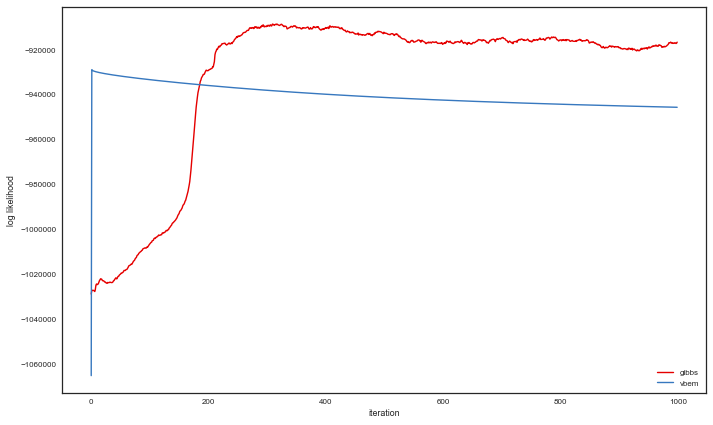

In [14]:
# Plot the log likelihoods
plt.figure(figsize=(10,6))
# plt.plot(np.arange(N_gibbs_samples), gibbs_lls, color=colors[0], label="gibbs")
# plt.plot(np.arange(N_gibbs_samples + 1, N_gibbs_samples + N_vbem_iters), vbem_lls[1:], color=colors[1], label="vbem")
# plt.xlim(0, N_gibbs_samples + N_vbem_iters)
plt.plot(gibbs_lls, color=colors[0], label="gibbs")
plt.plot(np.array(vbem_lls), color=colors[1], label="vbem")
# plt.xlim([950, 1000])
plt.xlabel('iteration')
plt.ylabel('log likelihood')
plt.legend(loc="lower right")
plt.tight_layout()
# plt.savefig("aux/demo_ll.png")

In [15]:
# Smooth the data
smoothed_data = test_model.smooth(unit_trial, inputs=inputs)

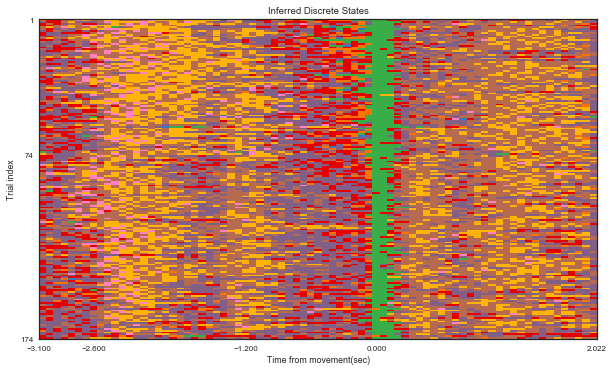

In [ ]:
fig = plt.figure(figsize=(10,80))
gs = GridSpec(3, 1, height_ratios=[.1, .1, 1.0])
ax = fig.add_subplot(gs[1,0])
timeRange = params['timeSeries'][0][0].flatten()
ax.imshow(test_model.states_list[0].stateseq.reshape(numTrial, numTime), vmin=0, vmax=max(len(colors), test_model.num_states)-1,
          cmap=cmap, interpolation="nearest", extent=[timeRange.min(),timeRange.max(),numTrial,1], aspect='auto')
ax.set_xticks([timeRange.min(), -2.6, -1.2, 0,timeRange.max()])
ax.set_yticks([numTrial, totTargets.sum(),1])
ax.set_xlabel('Time from movement(sec)')
ax.set_ylabel('Trial index')
ax.set_title("Inferred Discrete States")
plt.show()

# ax = fig.add_subplot(gs[2,0])
# plt.plot(y[:,0], color='k', lw=2, label="observed")
# plt.plot(smoothed_data[:,0], color=colors[0], lw=1, label="smoothed")
# plt.xlabel("Time")
# plt.xlim(0, min(T, 500))
# plt.ylabel("Observations")
# plt.legend(loc="upper center", ncol=2)
# plt.tight_layout()
# # d
# # 
# plt.figure()
# from pyhsmm.util.general import rle
# z_rle = rle(z)
# offset = 0
# for k, dur in zip(*z_rle):
#     plt.plot(x[offset:offset+dur,0], x[offset:offset+dur,1], color=colors[k])
#     offset += dur

# plt.xlabel("$x_1$")
# plt.ylabel("$x_2$")
# plt.title("Continuous Latent States")
# plt.show()